# Try out making the intersections csv for leapfrog
aim is: fault_name, fault_id (number in hierarchy order), terminations, extra_terminations
where terminations gives the IDs of faults higher up the order which the fault is truncated by with a + for truncation on and a -  for the other side
extra_terminations are those which occur at depth + might be harder to sort!
e.g. fault_name,fault_id,terminations,extra_terminations
Alpine combined,1,,
Hope  combined,2,+1,
Jordan Kekerengu Needles combined,3,+2,
Wairarapa combined,4,+3,
Wellington Hutt Valley combined,5,,+4

In [184]:
import os.path
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
from shapely.ops import unary_union
from shapely.geometry import Polygon

from fault_mesh.faults.leapfrog import LeapfrogMultiFault
from fault_mesh.faults.connected import ConnectedFaultSystem
from fault_mesh.utilities.graph import connected_nodes

In [80]:
#read in faults
# note D90 is the seismogenic thickness, whereas Dfc is the theoretical maximum rupture depth (see p. 30 of the CFM report)
# warnings about expected fields because of changes in naming conventions of CFM - should be fine
script_dir=os.path.abspath(".")
data = LeapfrogMultiFault.from_nz_cfm_shp("/home/UOCNT/cpe88/PycharmProjects/kaikoura/fault_model/qgis_files/cfm_cut.gpkg", remove_colons=True,
                                        exclude_zero=False, depth_type="Dfc", exclude_aus=False)

missing expected field
missing expected field


In [81]:
#read in edited faults
data.read_fault_systems(fault_system_csv=os.path.join(script_dir,"kaikoura_suggested_faults_edited_cfm.csv"))

data.generate_curated_faults()

data.read_cutting_hierarchy(os.path.join(script_dir,"kaikoura_hierarchy_v3_for_py.csv"))

In [175]:
traces={"Name":[],"geometry":[]}

for fault in data.curated_faults:
    #print(fault.name)
    trace = gpd.GeoSeries(fault.nztm_trace)
    traces["Name"].append(fault.name)
    traces["geometry"].append(trace.iloc[0])

AttributeError: 'ConnectedFaultSystem' object has no attribute 'down_dip_polygon'

In [157]:
#make geodataframe of traces
trace_gd=gpd.GeoDataFrame(traces,geometry='geometry',crs="EPSG:2193")


/tmp/ipykernel_658627/3141635591.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


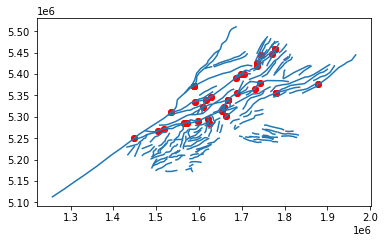

In [158]:
#find all intersections between fault traces (including with themselves)
int_and_self=gpd.overlay(trace_gd,trace_gd,how='intersection',keep_geom_type=False)
#remove self-intersections
trace_intersections=int_and_self.loc[int_and_self['Name_1']!=int_and_self['Name_2']]
fig,ax=plt.subplots()
trace_gd.plot(ax=ax)
trace_intersections.plot(ax=ax,c="r")
fig.show()

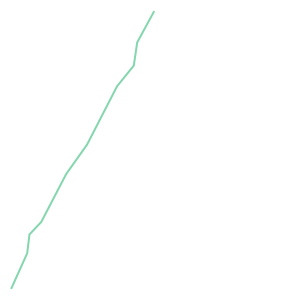

In [159]:
fault.nztm_trace

In [160]:
# sort first column into order of fault hierarchy
sorter=[name.strip('\n') for name in data.cutting_hierarchy]
sort_faults=[s for s in sorter if s in trace_intersections.Name_1.unique()]
TI=trace_intersections.set_index('Name_1').loc[sort_faults].reset_index()

In [161]:
# remove duplicate points
# actually want to remove higher index pairing of Name_1 and Name_2
pair_list=list(zip(TI['Name_1'],TI["Name_2"]))
pair_rev=list(zip(TI['Name_2'],TI["Name_1"]))
pair_names=dict([ (name,i) for i,name in enumerate(pair_list)] )
dup_ind=[i for i,pair in enumerate(pair_list) if pair in pair_rev[:i]]
TI.drop(dup_ind,inplace=True)


In [162]:
# number corresponding to each fault
fault_numbers=dict(zip(sorter,np.arange(1,len(data.cutting_hierarchy)+2)))



In [163]:
faults_with_intersections=np.unique(TI['Name_2'])
int_dict={}
for fault in faults_with_intersections:
    idxs=np.where(TI['Name_2']==fault)
    inter1=TI['Name_1'].iloc[np.min(idxs)]
    inter2=TI['Name_1'].iloc[np.max(idxs)]
    if inter1 == inter2:
        trunc="+" + str(fault_numbers[inter1])
    else:
        trunc=f"+{str(fault_numbers[inter1])}/+{str(fault_numbers[inter2])}"
    int_dict[fault]=trunc

In [164]:
int_dict

{'Akatarawa': '+5/+53',
 'Awatere Southwest': '+1/+7',
 'Barefell': '+7',
 'Campbell Bank': '+19',
 'Chancet': '+27',
 'Cloudy combined': '+24',
 'Dillon': '+9',
 'Fidget': '+3',
 'Hanmer': '+2',
 'Honeycomb Ridge': '+15',
 'Hope  combined': '+1',
 'Hope Hanmer NW': '+2',
 'Hope Taramakau': '+2',
 'Jordan Kekerengu Needles combined': '+2',
 'Kakapo': '+2',
 'Kowhai': '+3',
 'Leader North': '+104',
 'Leader South': '+104',
 'London Hill': '+3',
 'Moonshine': '+53/+59',
 'Offshore Splay Thrust': '+128',
 'Ohariu South combined': '+39',
 'Pahaua': '+29',
 'Pahaua SE1': '+29/+41',
 'Papatea': '+3/+35',
 'Shepherds Gully - Mana': '+45/+75',
 'Shingle Peak': '+8',
 'Vernon combined': '+7',
 'Wairau combined': '+1',
 'Whangamoa': '+1/+6'}

In [165]:
with open('intersections_test.csv','w') as file_out:
    file_out.write("fault_name,fault_id,terminations,extra_terminations\n")
    for fault in sorter:
        if fault in int_dict.keys():
            file_out.write(f'{fault},{fault_numbers[fault]},{int_dict[fault]},\n')
        else:
            file_out.write(f'{fault},{fault_numbers[fault]},,\n')

### Now try with polygons:

In [196]:
traces={"Name":[],"geometry":[]}

for fault in data.curated_faults:
    #print(fault.name)
    trace = gpd.GeoSeries(fault.nztm_trace)
    traces["Name"].append(fault.name)
    traces["geometry"].append(trace.iloc[0])

down_dips={"Name":[],"geometry":[]}
for fault in data.curated_faults:
    if isinstance(fault,ConnectedFaultSystem):
        fault_polys=[seg.down_dip_polygon for seg in fault.segments]
        down_dips['Name'].append(fault.name)
        down_dips['geometry'].append(unary_union(fault_polys))
    else:
        down_dips['Name'].append(fault.name)
        down_dips['geometry'].append(fault.down_dip_polygon)

In [197]:
#make geodataframe of downdip polys
dd_gd=gpd.GeoDataFrame(down_dips,geometry='geometry',crs="EPSG:2193")

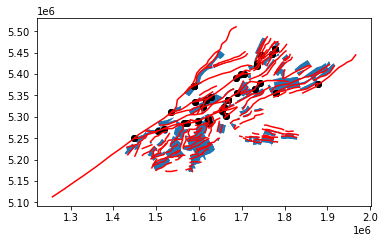

In [208]:
#find all intersections between fault traces (including with themselves)
dd_int_and_self=gpd.overlay(dd_gd,dd_gd,how='intersection',keep_geom_type=False)
#remove self-intersections
dd_intersections=dd_int_and_self.loc[dd_int_and_self['Name_1']!=dd_int_and_self['Name_2']]
fig,ax=plt.subplots()
trace_gd.plot(ax=ax,edgecolor='r')
dd_intersections.plot(ax=ax)
trace_intersections.plot(ax=ax,c='k')
fig.savefig('intersections.jpg',dpi=450)